# Project 6: IMDB

This project involves NLP, decision trees, bagging, boosting, and more!

---

## Load packages

You are likely going to need to install the `imdbpie` package:

    > pip install imdbpie

---

In [1]:
# import os
# import subprocess
# import collections
# import re
# import csv
# import json

import pandas as pd
import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# import psycopg2
# import requests
# from imdbpie import Imdb

# import urllib
# from bs4 import BeautifulSoup
# import nltk

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---

## Part 1: Acquire the Data

You will connect to the IMDB API to query for movies. 

See here for documentation on how to use the package:

https://github.com/richardasaurus/imdb-pie

#### 1. Connect to the IMDB API

In [16]:
imdb = Imdb()
imdb = Imdb(anonymize=True)
imdb = Imdb(cache=True)

#### 2. Query the top 250 rated movies in the database

In [17]:
top_250 = imdb.top_250()

#### 3. Make a dataframe from the movie data

Keep the fields:

    num_votes
    rating
    tconst
    title
    year
    
And discard the rest

In [18]:
# check type

type(top_250)

list

In [19]:
# view json

top_250[0]

{u'can_rate': True,
 u'image': {u'height': 1388,
  u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg',
  u'width': 933},
 u'num_votes': 1660702,
 u'rating': 9.3,
 u'tconst': u'tt0111161',
 u'title': u'The Shawshank Redemption',
 u'type': u'feature',
 u'year': u'1994'}

In [20]:
# pull select contents of json into a dictionary for dataframe transformation

dict_for_df = {}
titles = []
num_votes = []
ratings = []
tconst = []
years = []
for i in top_250:
    titles.append(i['title'])
    num_votes.append(i['num_votes'])
    ratings.append(i['rating'])
    tconst.append(i['tconst'])
    years.append(i['year'])

dict_for_df.update({'title': titles, 'num_votes': num_votes, 'rating': ratings, 'tconst': tconst, 'year': years})


In [21]:
# create dataframe

df = pd.DataFrame(dict_for_df)

#### 3. Select only the top 100 movies

In [22]:
# select top 100 by sorting values of rating

df.sort_values(by='rating', ascending=False, inplace=True)

top_hund = df.iloc[:100,:]
top_hund.shape

(100, 5)

In [23]:
# view one row

top_hund[top_hund.title == 'The Shawshank Redemption']

,num_votes,rating,tconst,title,year
0,1660702,9.3,tt0111161,The Shawshank Redemption,1994


In [44]:
top_hund.title.nunique()

100

#### 4. Get the genres and runtime for each movie and add them to the dataframe

There can be multiple genres per movie, so this will need some finessing.

In [24]:
# use OMDB API to pull genre and runtime

list_runtime = []
list_genre = []
for entry in top_hund.tconst:
    requ = requests.get('http://www.omdbapi.com/?i='+entry)
    requ_json = json.loads(requ.text)
    list_runtime.append(requ_json['Runtime'])
    list_genre.append(requ_json['Genre'])

In [25]:
# add genre and runtime to top hundred dataframe

genre_series = pd.Series(list_genre, index=top_hund.index).str.split(', ')
top_hund.ix[:,'genre'] = genre_series

runtime_series = pd.Series(list_runtime, index=top_hund.index).str.strip(' min')
top_hund.ix[:, 'runtime'] = runtime_series

/Users/michaelshea/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/michaelshea/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
# split genre column into dummy columns

dummy_df = pd.get_dummies(top_hund.genre.apply(pd.Series).stack()).sum(level=0)

top_hund = top_hund.join(dummy_df)

*Note: Above I created a separate column for each genre*

#### 4. Write the Results to a csv

In [21]:
# use to_csv

top_hund.to_csv('top_hund', encoding='utf-8')

---

## Part 2: Wrangle the text data

#### 1. Scrape the reviews for the top 100 movies

*Hint*: Use a loop to scrape each page at once

__NOTE: I used the API, rather than scrape__

In [105]:
# Generate lists of review text and ratings
rev_text = []
rev_rating = []
movie_id = []

# The below two lines of code are from stack overflow, help removing non-aphanums from unicode
translation_table = dict.fromkeys(map(ord, "*!')(@#$-"), None)
# this line may no longer be needed: unicode_line = unicode_line.translate(translation_table)

for id in top_hund.tconst:
    reviews = imdb.get_title_reviews(id, max_results=250)
    for i in reviews:
        rev_text.append((i.text.translate(translation_table)).lower())
        rev_rating.append(i.rating)
        movie_id.append(id)

In [106]:
len(rev_rating)

24403

In [107]:
len(rev_text)

24403

In [108]:
len(movie_id)

24403

In [109]:
type(rev_text[0])

unicode

In [110]:
# view single review

rev_text[0]

u'why do i want to write the 234th comment on the shawshank redemption? i am not sure  almost everything that could be possibly said about it has been said. but like so many other people who wrote comments, i was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. \n\nthe only other movie i have ever seen that effects me as strongly is to kill a mockingbird. both movies leave me feeling cleaner for having watched them.\n\ni didnt intend to see this movie at all: i do not like prison movies and i dont normally watch them. i work at a branch library and one day as i was checking the shawshank redemption out to one of our older patrons, she said to me, "whenever i feel down or depressed, i check out this movie and watch it and it always makes me feel better." at the time, i thought that was very strange. one day there was nothing on tv except things i absolutely would not watch under any circumstance or things that i had seen too many times

#### 2. Extract the reviews and the rating per review for each movie

*Note*: "soup" from BeautifulSoup is the html returned from all 25 pages. You'll need to either address each page individually or break them down by elements.

##### **done above using API**

#### 3. Remove the non AlphaNumeric characters from reviews

##### done above in for loop (block 105)

In [113]:
# create empty dataframe called reviews_df

reviews_df = pd.DataFrame()

In [114]:
# add movie_id, rev_rating, rev_text

reviews_df['movie_id'] = movie_id
reviews_df['review_rating'] = rev_rating
reviews_df['review_text'] = rev_text

In [115]:
# slice out column with review text (prep for vectorizer)

just_text = reviews_df.review_text

In [121]:
reviews_df.head()

,movie_id,review_rating,review_text
0,tt0111161,10.0,why do i want to write the 234th comment on th...
1,tt0111161,10.0,"\ncan hollywood, usually creating things for e..."
2,tt0111161,NaN,\ni have never seen such an amazing film since...
3,tt0111161,10.0,"in its oscar year, shawshank redemption writte..."
4,tt0111161,NaN,the reason i became a member of this database ...


#### 4. Calculate the top 200 ngrams from the user reviews

Use the `TfidfVectorizer` in sklearn.

Recommended parameters:

    ngram_range = (1, 2)
    stop_words = 'english'
    binary = False
    max_features = 200

In [118]:
# Use TfidVectorizer with arguments listed above

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english', binary = False, max_features = 200)


In [119]:
# Fit on review text

vectorizer.fit(just_text)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=200, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [120]:
# Transform into dense matrix

ngram_df = pd.DataFrame(vectorizer.transform(just_text).todense(),
             columns=vectorizer.get_feature_names(), index = reviews_df.index.values)

In [122]:
# View dense matrix

ngram_df.head()

,10,acting,action,actor,actors,actually,amazing,american,audience,away,...,watched,watching,way,wife,wonderful,work,world,year,years,young
0,0.000000,0.000000,0.090854,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.30572,0.000000,0.000000,0.000000,0.0,0.087107,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.102612,0.000000,0.0,0.118742,0.0,0.062862,0.000000,0.265061,0.000000,...,0.00000,0.000000,0.044561,0.073825,0.0,0.168731,0.106523,0.000000,0.000000,0.063477
2,0.000000,0.124850,0.000000,0.0,0.000000,0.0,0.152970,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.066879,0.000000,0.000000,0.0,0.072440,0.0,0.076699,0.085465,0.000000,0.074372,...,0.00000,0.068454,0.000000,0.000000,0.0,0.000000,0.129971,0.087628,0.065314,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [124]:
# View reviews_df head

reviews_df.head()

,movie_id,review_rating,review_text
0,tt0111161,10.0,why do i want to write the 234th comment on th...
1,tt0111161,10.0,"\ncan hollywood, usually creating things for e..."
2,tt0111161,NaN,\ni have never seen such an amazing film since...
3,tt0111161,10.0,"in its oscar year, shawshank redemption writte..."
4,tt0111161,NaN,the reason i became a member of this database ...


#### 5. Merge the user reviews and ratings

In [126]:
# Merge using join

merged_reviews_ngrams = reviews_df.join(ngram_df)

In [127]:
# View merged head

merged_reviews_ngrams.head(2)

,movie_id,review_rating,review_text,10,acting,action,actor,actors,actually,amazing,...,watched,watching,way,wife,wonderful,work,world,year,years,young
0,tt0111161,10.0,why do i want to write the 234th comment on th...,0.000000,0.000000,0.090854,0.0,0.000000,0.0,0.000000,...,0.30572,0.000000,0.000000,0.000000,0.0,0.087107,0.000000,0.000000,0.000000,0.000000
1,tt0111161,10.0,"\ncan hollywood, usually creating things for e...",0.000000,0.102612,0.000000,0.0,0.118742,0.0,0.062862,...,0.00000,0.000000,0.044561,0.073825,0.0,0.168731,0.106523,0.000000,0.000000,0.063477
2,tt0111161,NaN,\ni have never seen such an amazing film since...,0.000000,0.124850,0.000000,0.0,0.000000,0.0,0.152970,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,tt0111161,10.0,"in its oscar year, shawshank redemption writte...",0.066879,0.000000,0.000000,0.0,0.072440,0.0,0.076699,...,0.00000,0.068454,0.000000,0.000000,0.0,0.000000,0.129971,0.087628,0.065314,0.000000
4,tt0111161,NaN,the reason i became a member of this database ...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [129]:
# Drop nulls -- i.e. the rows w/out a rating

merged_reviews_ngrams.dropna(axis = 0, inplace = True)

In [131]:
# Drop review column, leaving ngram columns

merged_reviews_ngrams.drop('review_text', axis=1, inplace = True)

In [132]:
# Check shape 

merged_reviews_ngrams.shape

(21065, 202)

#### 6. Save this merged dataframe as a csv

In [134]:
# Use to_csv

merged_reviews_ngrams.to_csv('reviews_better', encoding= 'utf-8')

---

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

In [8]:
# Import sqlalchemy

from sqlalchemy import create_engine

In [9]:
# Create engine mapping to my local postgres

engine = create_engine('postgresql://michaelshea@localhost:5432/project_6')

In [138]:
# Push merged_reviews_ngrams DataFrame to sql

merged_reviews_ngrams.to_sql('reviews', engine, flavor='postgres', if_exists='replace')

In [30]:
# Push top_hun DataFrame to sql

top_hund.to_sql('movies_better', engine, flavor='postgres', if_exists='replace')

#### 2. Connect to database and query the joined set

In [2]:
# use iPython sql magic

%load_ext sql

/Users/michaelshea/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/michaelshea/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [3]:
%%sql 
postgresql://michaelshea@localhost:5432/project_6

u'Connected: michaelshea@project_6'

In [4]:
# Try a sql query, see if it works

%sql SELECT * FROM movies_BETTER LIMIT 2;

2 rows affected.


index,num_votes,rating,tconst,title,year,genre,runtime,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1660702,9.3,tt0111161,The Shawshank Redemption,1994,"{Crime,Drama}",142,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1136669,9.2,tt0068646,The Godfather,1972,"{Crime,Drama}",175,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Try another on the other table - check datatypes

%sql SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'reviews' LIMIT 7;

7 rows affected.


column_name,data_type
index,bigint
movie_id,text
review_rating,double precision
10,double precision
acting,double precision
action,double precision
actor,double precision


#### 3. Join the two tables 

In [35]:
joined_df = %sql SELECT * FROM movies_better INNER JOIN reviews ON movies_better.tconst = reviews.movie_id;

20413 rows affected.


In [14]:
movie_cols = %sql SELECT column_name FROM information_schema.columns WHERE table_name = 'movies';

28 rows affected.


column_name
index
num_votes
rating
tconst
title
year
genre
runtime
Action
Adventure


#### 4. Select the newly joined table and save two copies of the into dataframes

In [6]:
# import pandas as pd

In [10]:
# use read_sql

movies_reviews = pd.read_sql('SELECT * FROM movies_better INNER JOIN reviews ON movies_better.tconst = reviews.movie_id;', engine)


In [11]:
type(movies_reviews)

pandas.core.frame.DataFrame

In [13]:
movies_reviews.to_csv('joined_thurs_2', encoding= 'utf-8')

---

## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename any columns you think should be renamed for clarity

In [2]:
path = '/Users/michaelshea/desktop/DSI-DC-1/week-06/Project 6/starter-code/joined_thurs_2'

In [3]:
movies_reviews = pd.read_csv(path)

In [4]:
movies_reviews.head(1)

,Unnamed: 0,index,num_votes,rating,tconst,title,year,genre,runtime,Action,...,watched,watching,way,wife,wonderful,work,world,year.1,years,young
0,0,0,1660702,9.3,tt0111161,The Shawshank Redemption,1994,"{Crime,Drama}",142,0.0,...,0.30572,0.0,0.0,0.0,0.0,0.087107,0.0,0.0,0.0,0.0


In [5]:
# retaining this code if I decide to use it again

# movies_reviews.rename(columns={movies_reviews.year:'year_shown'}, inplace=True)
# movies_reviews.runtime = pd.to_numeric(movies_reviews.runtime, errors='coerce')
# movs_revs_grouped = movies_reviews.groupby('title').mean()
# movs_revs_grouped.drop('genre', axis=1, inplace=True)

#### 2. Describe anything interesting or suspicious about your data (quality assurance)

##### NOTE I somehow lost three movies in the shuffle, as demonstrated by the code directly below.

In [5]:
# I somehow lost three movies in the shuffle

movies_reviews.title.nunique()

97

#### 3. Make four visualizations of interest to you using the data

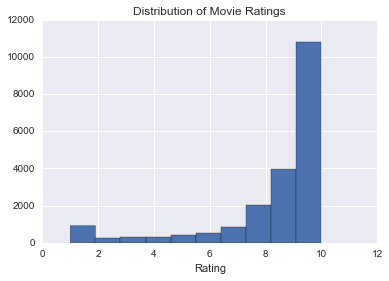

In [6]:
plt.hist(movies_reviews.review_rating)
plt.xlabel("Rating")
plt.title("Distribution of Movie Ratings")

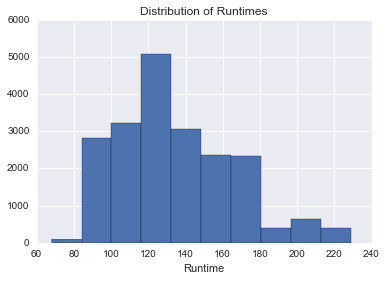

In [7]:
plt.hist(movies_reviews.runtime)
plt.xlabel("Runtime")
plt.title("Distribution of Runtimes")

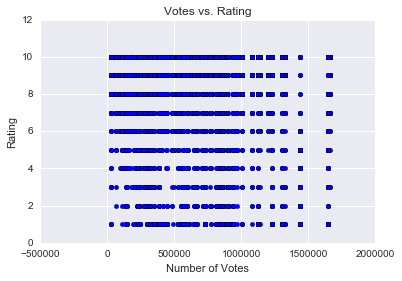

In [8]:
plt.scatter(movies_reviews.num_votes, movies_reviews.review_rating)
plt.xlabel("Number of Votes")
plt.ylabel("Rating")
plt.title("Votes vs. Rating")

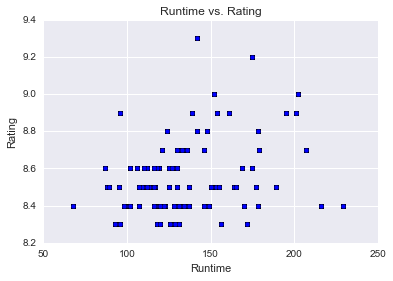

In [9]:
plt.scatter(movies_reviews.runtime, movies_reviews.rating)
plt.xlabel("Runtime")
plt.ylabel("Rating")
plt.title("Runtime vs. Rating")

---

## Part 5: Decision Tree Classifiers and Regressors

#### 1. What is our target attribute? 

Choose a target variable for the decision tree regressor and the classifier. 

For decision tree regressor, I will predict the rating.

#### 2. Prepare the X and Y matrices and preprocess data as you see fit

In [6]:
# Create X with all vectorized columns, plus runtime, year, genres, and num_votes

X = movies_reviews.drop(['Unnamed: 0', 'index', 'rating', 'tconst', 'genre', 'index.1', 'title', 'movie_id', 'review_rating'], axis = 1)

In [7]:
# Scale X

from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scalar.fit(X)
X_scaled = scalar.transform(X)

In [8]:
# create regression target 

y = movies_reviews.review_rating

In [9]:
# create a target for classication

y_class = y.map({1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:3, 9:3, 10:3})

In [16]:
y.value_counts()

10.0    10814
9.0      3970
8.0      2010
1.0       915
7.0       848
6.0       534
5.0       428
4.0       335
3.0       320
2.0       239
Name: review_rating, dtype: int64

In [17]:
y_class.value_counts()

3    16794
2     2145
1     1474
Name: review_rating, dtype: int64

In [19]:
print X.shape
print y.shape
print y_class.shape

(20413, 223)
(20413,)
(20413,)


In [18]:
X.head()

,num_votes,year,runtime,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,...,watched,watching,way,wife,wonderful,work,world,year.1,years,young
0,1660702,1994,142,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.30572,0.000000,0.000000,0.000000,0.0,0.087107,0.000000,0.000000,0.000000,0.000000
1,1660702,1994,142,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.00000,0.000000,0.044561,0.073825,0.0,0.168731,0.106523,0.000000,0.000000,0.063477
2,1660702,1994,142,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.00000,0.068454,0.000000,0.000000,0.0,0.000000,0.129971,0.087628,0.065314,0.000000
3,1660702,1994,142,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.00000,0.145045,0.115203,0.190859,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,1660702,1994,142,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


*__To recap:__ our feature matrix X contains 20,000 rows and 223 columns. Each row represents a separate review and the columns are our features. I plan on predicting review rating based on a combination of text data and movie attributes.*

In [130]:
len(X.columns)

50

#### 3. Build and cross-validate your decision tree classifier

In [10]:
# Import cross_val_score and DecisionTreeClassifier

from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [11]:
# instantiate Decision Tree Classifier

dtc = DecisionTreeClassifier()

In [12]:
# Fit on y_class, which is the binned ratings

dtc.fit(X,y_class)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [13]:
scores = cross_val_score(dtc, X, y_class, cv = 10, scoring='accuracy')

In [21]:
# Mean accuracy score for 10 folds
print "Cross-validation mean accuracy score:"
print scores.mean()

Cross-validation mean accuracy score:
0.589696815361


#### 4. Gridsearch optimal parameters for your classifier. Does the performance improve?

In [19]:
Parameters = {'max_depth':range(1,10), 'max_features':[5,10,20,30,50,100,150,200]}

Scoring = 'accuracy'

In [20]:
#Grid Search

from sklearn.grid_search import GridSearchCV

model = DecisionTreeClassifier()
clf = GridSearchCV(model, Parameters, scoring=Scoring, verbose=True, n_jobs=-1)
clf.fit(X, y_class)

#After completion, show the final best results and scores
print clf.best_estimator_
print clf.best_score_
# print np.sqrt(-clf.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   19.6s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=50, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.829030519767


### Interpretation:
#### The performance improved immensly post gridsearch: from 58% to 83% accuracy!
However gridsearchCV may be overfitting the decision tree classifier, so caution is warranted.

It's also important to note that I binned my target into three categories:
- low score: 1-3
- medium score: 4-7
- high score: 8-10

This binning makes intuitive sense and will also improve the performance of my classifier.

#### 5. Build and cross-validate your decision tree regressor

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
dtr = DecisionTreeRegressor()

In [24]:
scores = cross_val_score(dtr, X, y, cv = 10, scoring = 'mean_squared_error')

In [25]:
print "Mean cross-val score (MSE):"
print scores

Mean cross-val score (MSE):
[ -9.02840353  -8.45837414  -7.75146915 -12.33917197  -6.42283195
  -8.61538462  -7.73799608  -9.48652621  -8.70063694  -8.95982362]


#### 6. Gridsearch the optimal parameters for your regressor. Does performance improve?

### Note:
#### *I chose not to complete the Decision Tree Regressor due to an issue that arose with the MSE outputting negative values.*

---

## Part 6: Elastic Net


#### 1. Gridsearch optimal parameters for an ElasticNet using the regression target and predictors you used for the decision tree regressor.


#### 2. Is cross-validated performance better or worse than with the decision trees? 

#### 3. Explain why the elastic net may have performed best at that particular l1_ratio and alpha

---

## Part 7: Bagging and Boosting: Random Forests, Extra Trees, and AdaBoost

#### 1. Load the random forest regressor, extra trees regressor, and adaboost regressor from sklearn

#### *Note: I feel that a classification approach is ideal in this case, so I will proceed with classifiers in this section, rather than regressors.*

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [27]:
from sklearn.ensemble import AdaBoostClassifier

#### 2. Gridsearch optimal parameters for the three different ensemble methods.

In [30]:
# Instantiate Random Forest Classifier

rfclass = RandomForestClassifier()

In [31]:
params = {'n_estimators':[5, 10, 50, 100],
          'criterion': ['gini', 'entropy'],
          'max_depth': [3, 5, 7, 9],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}

In [35]:
gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=10)

In [37]:
gsrf.fit(X, y_class)
print gsrf.best_params_
print gsrf.best_score_

{'min_samples_split': 2, 'n_estimators': 5, 'criterion': 'entropy', 'max_depth': 9, 'class_weight': None}
0.827168960956


## Note:
### *Due to the computational strain these gridsearches placed on my machine, I was unable to complete the remaining tasks. Please see my markdown document for a discussion of the findings from this analysis, up to this stage.*

#### 3. Evaluate the performance of the two bagging and one boosting model. Which performs best?

#### 4. Extract the feature importances from the Random Forest regressor and make a DataFrame pairing variable names with their variable importances.

#### 5. Plot the ranked feature importances.

#### 6.1 [BONUS] Gridsearch an optimal Lasso model and use it for variable selection (make a new predictor matrix with only the variables not zeroed out by the Lasso). 

#### 6.2 [BONUS] Gridsearch your best performing bagging/boosting model from above with the features retained after the Lasso. Does the score improve?

#### 7.1. [BONUS] Select a threshold for variable importance from your Random Forest regressor and use that to perform feature selection, creating a new subset predictor matrix.

#### 7.2 [BONUS] Using BaggingRegressor with a base estimator of your choice, test a model using the feature-selected dataset you made in 7.1

---

## [VERY BONUS] Part 8: PCA

#### 1. Perform a PCA on your predictor matrix

#### 2. Examine the variance explained and determine what components you want to keep based on them.

#### 3. Plot the cumulative variance explained by the ordered principal components.

#### 4. Gridsearch an elastic net using the principal components you selected as your predictors. Does this perform better than the elastic net you fit earlier?

#### 5. Gridsearch a bagging ensemble estimator that you fit before, this time using the principal components as predictors. Does this perform better or worse than the original? 

#### 6. Look at the loadings of the original predictor columns on the first 3 principal components. Is there any kind of intuitive meaning here?

Hint, you will probably want to sort by absolute value of magnitude of loading, and also only look at the obviously important (larger) ones!

# [Extremely Bonus] Part 9:  Clustering

![](https://snag.gy/jPSZ6U.jpg)

 ***Bonus Bonus:***
This extended bonus question is asking to do something we never really talked about but would like for you to attempt based on the assumptions that we learned during this weeks clustering lesson(s).

#### 1. Import your favorite clustering module

#### 2. Encode categoricals

#### 3. Evaluate cluster metics solely based on a range of K
If K-Means:  SSE/Inertia vs Silhouette (ie: Elbow), silhouette average, etc

#### 4.  Look at your data based on the subset of your predicted clusters.
Assign the cluster predictions back to your dataframe in order to see them in context.  This is great to be able to group by cluster to get a sense of the data that clumped together.

#### 5. Describe your findings based on the predicted clusters 
_How well did it do?  What's good or bad?  How would you improve this? Does any of it make sense?_